# Correlation models 
This example shows how PCM can be used to test hypotheses about the correlation between two sets of activity patterns. For more information, see our [*Brain, Data, and Science*](http://diedrichsenlab.org/BrainDataScience/noisy_correlation) blog on this topic. 

In this example we will simulate data from a hypothetical experiment, in which participants observe 3 hand gestures or execute the same 3 hand gestures. In this case we have three items (actions) observed under 2 conditions. We are interested in the average correlation between the patterns associated with observing and execution action A, observing and execution action observing and execution action B, and observing and execution action C. In this, we would like to account for the general correlation between the average patterns of observing and executing. 

To solve this problem, we calculate the likelihood of the data, given specific correlations $p(Y|r)$. Additionally to the correlation, we need to deal with some additional parameters. In our case this is the variance in the activity patterns associated with observing different actions, and the variance associated with execution different actions. These hyper-parameter express the strength of the encoding and are directly related to the average inter-item distance in an RSA analysis. Additionally, we need to consider a pattern component that is caused by the condition itself (observing or executing actions), common to all items. Finally, we need a parameter that determines the noise variance. These hyper-parameters are collectively referred to by $\theta$. Here we will compare different models by using the (Type II) maximum likelihood to approximate the model evidence. 

$$
p(Y|r) \approx \underset{\theta}{\operatorname{max}}{p(Y|r,\theta)}.
$$

These may seem like a bit of a cheat, but works in this this case quite well. Estimating parameters on the same data that you use to evaluate the model of course leads to an overestimation of the likelihood. However, as the number of hyper-parameters is low and all correlation models have the same number of parameters, this bias will be approximately stable across all models. Since we are interested in the *difference* in log-likelihood across models, this small bias simply disappears. If you want to compare models with different numbers of parameters, a more sophisticated approach, such as group-cross-validation is required. 

In [1]:
# First import necessary libraries
import PcmPy as pcm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import exp, sqrt
import scipy.stats as ss

## Data simulation
First, we make our true model - one where the all action are equally stronly encoded in each conditions - but where the strength of encoding can differ between condition - certainly it is expected to be smaller during observation than during execution. We also model the covariance between items within condition with a condition effect.
Let's say the correlation is 0.7. 

In [2]:
Mtrue = pcm.CorrelationModel('corr',num_items=3, corr=0.7, cond_effect=True, within_cov=None)
print(f"The model has {Mtrue.n_param} hyper parameters")

The model has 4 hyper parameters


These four parameters are concerned with the condition effect and item effects for observation and execution respectively. Visualizing the components of the second moment mattrix helps to understand this.  

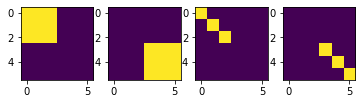

In [3]:
H = Mtrue.n_param
for i in range(H):
    plt.subplot(1,H,i+1)
    plt.imshow(Mtrue.Gc[i,:,:])

To Simulate a data set, we need to make a design. Let's assume we measure the 6 trial types in 8 imaging runs and submit the beta-values from each run to the model as $\mathbf{Y}$. 

We then generate a data set where there is a strong effect of both observation (exp(0)) and execution (exp(1)) 
The item effects for observation (exp(-1.5)) and execution ((exp(-1))) are pretty weak in comparision, as it typical 
Note that all hyper parameters are log(variances) - this helps us to keep variances positive and the math easy. 

In [4]:

# Make the design in this case it's 8 runs, 6 conditions!
cond_vec,part_vec = pcm.sim.make_design(6,8)
# Generate 20 data sets with pretty low signal to noise (1:10)
D = pcm.sim.make_dataset(Mtrue, [0,0.5,-0.5,-0.5], cond_vec, part_vec=part_vec,n_sim=12, signal=0.4)
    

As a quick check, let's plot the predicted second moment matrix of our model (for the simulation parameters) and the crossvalidated estimate from the first data set. 

Text(0.5, 1.0, 'data set')

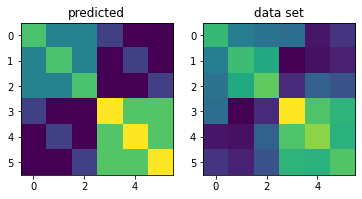

In [5]:
 # Get the predicted G-matrix 
 G,_ = Mtrue.predict([0,0.5,-0.5,-0.5])
# The estimated G-matrix from the data 
trial_type = D[1].obs_descriptors['cond_vec']
G_hat,_ = pcm.est_G_crossval(D[1].measurements,trial_type,part_vec)
plt.subplot(1,2,1)
plt.imshow(G)
plt.title('predicted')
plt.subplot(1,2,2)
plt.imshow(G_hat)
plt.title('data set')



## Fitting the data 
Now we are fitting these data sets with a range of models assuming a correlation between -1 and 1. The other parameters will still be included, like in the true model. 
We also include a flexible correlation model, which has a additional free parameter that model the correlation. 

In [6]:
nsteps=21 # 21 models  
M=[]
# Generate the models equally spaced between -1 and 1 
for r in np.linspace(-1,1,nsteps):
    M.append(pcm.CorrelationModel(f"{r:0.2f}",num_items=3,corr=r,cond_effect=True))
# Now make the flexible model 
Mflex = pcm.CorrelationModel("flex",num_items=3,corr=None,cond_effect=True)
M.append(Mflex)

We can now fit the model to the data sets in one go. The resulting data frame `T` has the log-likelihoods for each model / data set. The second return argument `theta` contains the parameters for each model fit. 

In [7]:
 # In this case we model the block effect as a mixed effect - we don't need to include a scale parameter, as we don't have a fixed model 
T,theta = pcm.fit_model_individ(D,M,fixed_effect='block',fit_scale=False,verbose=False)

T

variable   likelihood                                                    \
model           -1.00        -0.90        -0.80       -0.70       -0.60   
0         -941.346922  -941.346922  -941.346922 -943.905154 -939.052666   
1         -963.255790  -963.255790  -963.255790 -964.989670 -960.658266   
2         -977.466351  -977.466351  -981.104807 -971.566383 -965.019533   
3         -878.943470  -878.943470  -878.943470 -878.943470 -883.299121   
4         -937.541361  -937.541361  -937.541361 -943.986282 -937.903511   
5         -959.922378  -959.922378  -967.157071 -957.686609 -951.126677   
6         -894.316665  -894.316665  -894.447352 -889.771757 -886.215981   
7         -911.966859  -911.966859  -911.966859 -918.258785 -912.184313   
8         -905.725007  -905.725007  -917.829986 -909.052852 -902.722999   
9        -1001.881171 -1026.377830 -1006.188539 -995.019762 -987.217681   
10        -945.423994  -945.423994  -950.748299 -942.900876 -937.247236   
11        -963.311866  -963.311866  -963.311866 -962.693557 -959.784867   

variable                                                              ...  \
model          -0.50       -0.40       -0.30       -0.20       -0.10  ...   
0        -935.243151 -932.176317 -929.648516 -927.530061 -925.737022  ...   
1        -957.254868 -954.536941 -952.325220 -950.503404 -948.996276  ...   
2        -960.104649 -956.217212 -953.039679 -950.387440 -948.146537  ...   
3        -879.133191 -875.688116 -872.790678 -870.311437 -868.162291  ...   
4        -933.134617 -929.244676 -925.972045 -923.155306 -920.690015  ...   
5        -946.169341 -942.222987 -938.974599 -936.241107 -933.908626  ...   
6        -883.567894 -881.564797 -880.039914 -878.890488 -878.053580  ...   
7        -907.418657 -903.529567 -900.256342 -897.437967 -894.970178  ...   
8        -897.867417 -893.958456 -890.706335 -887.938234 -885.544805  ...   
9        -981.234521 -976.388805 -972.321637 -968.822271 -965.757975  ...   
10       -932.948670 -929.532521 -926.735623 -924.400937 -922.430042  ...   
11       -957.406244 -955.487411 -953.936860 -952.684954 -951.683730  ...   

variable iterations                                                 
model          0.20 0.30 0.40 0.50 0.60 0.70 0.80  0.90  1.00 flex  
0               6.0  6.0  6.0  6.0  6.0  6.0  6.0   6.0   6.0  6.0  
1               6.0  6.0  6.0  6.0  6.0  6.0  6.0   6.0   7.0  6.0  
2               6.0  7.0  7.0  7.0  7.0  7.0  7.0   7.0   7.0  7.0  
3               6.0  6.0  6.0  6.0  6.0  6.0  6.0   6.0   6.0  6.0  
4               6.0  6.0  6.0  6.0  7.0  7.0  7.0   7.0   7.0  7.0  
5               6.0  6.0  6.0  6.0  6.0  6.0  6.0   6.0   6.0  6.0  
6               6.0  6.0  6.0  6.0  6.0  6.0  6.0  10.0  12.0  6.0  
7               6.0  6.0  6.0  6.0  6.0  6.0  6.0   6.0   6.0  6.0  
8               6.0  6.0  7.0  7.0  7.0  7.0  7.0   7.0   7.0  7.0  
9               6.0  6.0  6.0  6.0  6.0  6.0  6.0   6.0   6.0  6.0  
10              6.0  6.0  6.0  6.0  6.0  6.0  6.0   6.0   6.0  6.0  
11              6.0  6.0  6.0  6.0  6.0  6.0  6.0   6.0   7.0  6.0  

[12 rows x 66 columns]

## Interpreting the Fit 
Not that the absolute values of the log-likelihoods doesn't mean much - so we first will remove the mean likelihood for each, expressing each as the differences against the mean. Then we plot the full log-likelihood curves and the maximum likelihood estimate of the correlation for each person. We can also add the mean log-likelihood curve.

Text(0, 0.5, 'log-likelihood')

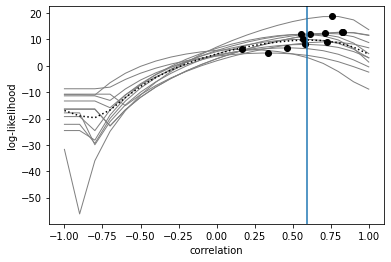

In [8]:
L = T.likelihood.to_numpy()

# express log-liklihoods relative to mean 
L = L - L.mean(axis=1).reshape(-1,1)
maxL = L[:,-1] # Last model is the flexible 
L = L[:,0:-1] # REmove it 

# Get the correlation for each of the models
r = np.empty((nsteps,))
for i in range(nsteps):
    r[i]= M[i].corr

# Get the maximum likelihood estimate of each parameter 
maxr = M[-1].get_correlation(theta[-1])

# Now we make the plot 
plt.plot(r,L.T,color='gray', marker=None, linewidth=1)
plt.plot(maxr,maxL,'k.',markersize=12)
plt.plot(r,L.mean(axis=0),'k:')
plt.axvline(maxr.mean())
plt.xlabel('correlation')
plt.ylabel('log-likelihood')

As we can see, the maximum likelihood estimates behave quite well, bit the mean of the maximum likelihood estimates is not exactly where the maximum of the mean (or group) likelihood lies. 

One way to use the log-liklihoods is to do a paired t-test between the log-likelihoods for two correlation values - for example 0.70 vs 0.3

In [9]:
print(f"Testing correlation of {r[13]:0.2f} against {r[17]:0.2f}")
R1=ss.ttest_rel(L[:,13],L[:,17])
print(R1)

Testing correlation of 0.30 against 0.70
Ttest_relResult(statistic=-1.5869669753542313, pvalue=0.1408272998879615)


Alternatively, we can transform the log-likelihoods in approximate posterior distributions, and proceed with a Full Bayesian group analysis. 
For more accurate results, you probably want to space your correlation models more tightly.

Text(0, 0.5, 'posterior probability')

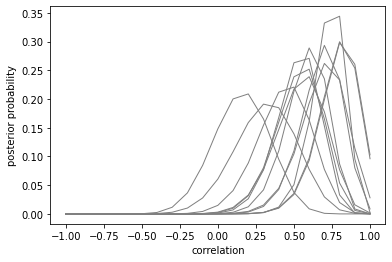

In [10]:
P = exp(L) # Take the exponential 
P = P / P.sum(axis=1).reshape(-1,1) # Normalize to 1 over domain 
plt.plot(r,P.T,color='gray', marker=None, linewidth=1)
plt.xlabel('correlation')
plt.ylabel('posterior probability')
